<a href="https://colab.research.google.com/github/Ilvecho/Project_5/blob/main/Project_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import and load data

In [1]:
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller


files.upload()
pass

Saving 2020Q1Q2Q3Q4-2021Q1 - South Korea - Dongkuk Steel Mill Co Ltd (001230).csv to 2020Q1Q2Q3Q4-2021Q1 - South Korea - Dongkuk Steel Mill Co Ltd (001230).csv
Saving 2020Q1Q2Q3Q4-2021Q1 - South Africa - Impala Platinum Holdings Ltd (IMPJ).csv to 2020Q1Q2Q3Q4-2021Q1 - South Africa - Impala Platinum Holdings Ltd (IMPJ).csv
Saving 2020Q1Q2Q3Q4-2021Q1 - Egypt - Medinet Nasr Housing (MNHD).csv to 2020Q1Q2Q3Q4-2021Q1 - Egypt - Medinet Nasr Housing (MNHD).csv
Saving 2020Q1Q2Q3Q4-2021Q1 - Turkey - Koc Holding AS (KCHOL).csv to 2020Q1Q2Q3Q4-2021Q1 - Turkey - Koc Holding AS (KCHOL).csv
Saving 2020Q1Q2Q3Q4-2021Q1 - Russia - Sberbank Rossii PAO (SBER).csv to 2020Q1Q2Q3Q4-2021Q1 - Russia - Sberbank Rossii PAO (SBER).csv
Saving 2020Q1Q2Q3Q4-2021Q1 - Argentina - Pampa Energia SA (PAMP).csv to 2020Q1Q2Q3Q4-2021Q1 - Argentina - Pampa Energia SA (PAMP).csv
Saving 2020Q1Q2Q3Q4-2021Q1 - Brazil - Minerva SA_Brazil (BEEF3).csv to 2020Q1Q2Q3Q4-2021Q1 - Brazil - Minerva SA_Brazil (BEEF3).csv
Saving 2020Q1Q2Q

In [2]:
file_list = os.listdir('/content/')
data = {}

for filename in file_list:
  if filename.startswith('2020Q1'):
    country = filename.split(' - ')[1].strip()
    tmp_data = pd.read_csv(filename)[:-1]
    tmp_data['Date'] = pd.to_datetime(tmp_data['Date'])
    tmp_data.set_index('Date', inplace=True)

    try:
      data[country] = tmp_data['Price'].astype(float).sort_index()
    except:
      tmp_data['Price'] = tmp_data['Price'].apply(lambda x: x.replace(',', ''))
      data[country] = tmp_data['Price'].astype(float).sort_index()

In [ ]:
for key in data.keys():
  print('\n\n###########\n')
  print(data[key].info())

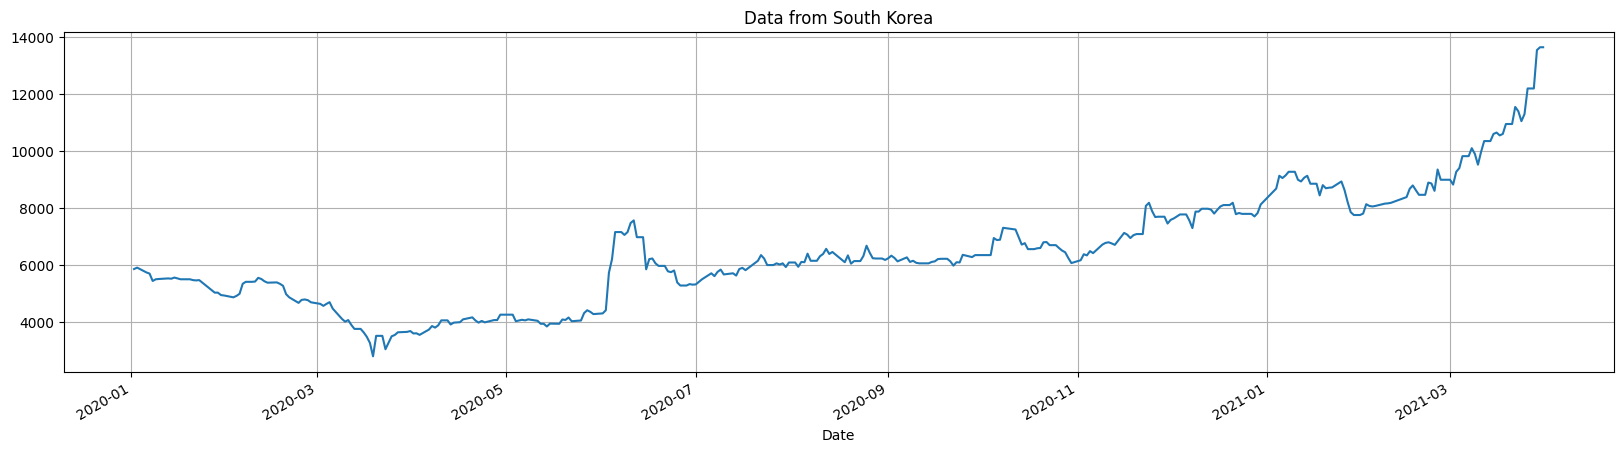

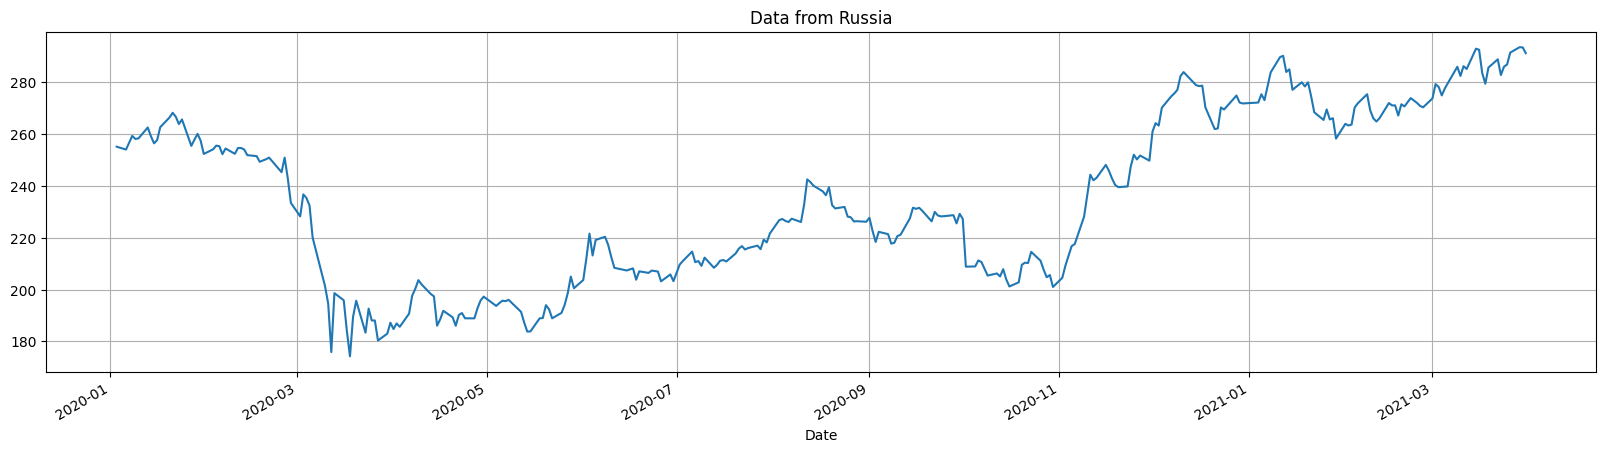

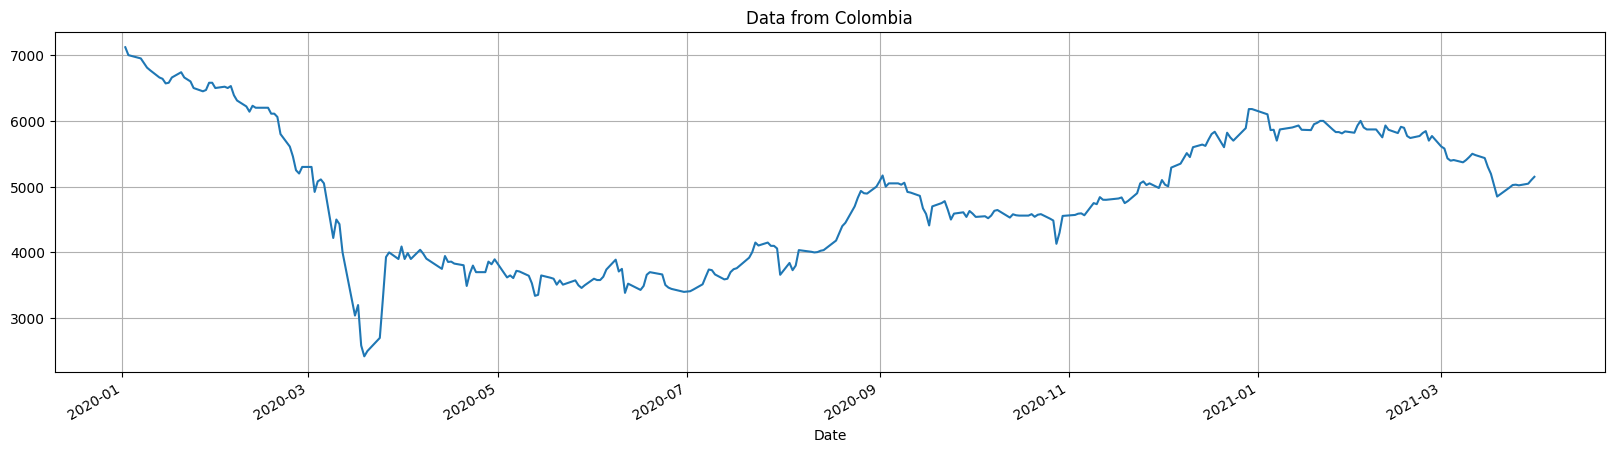

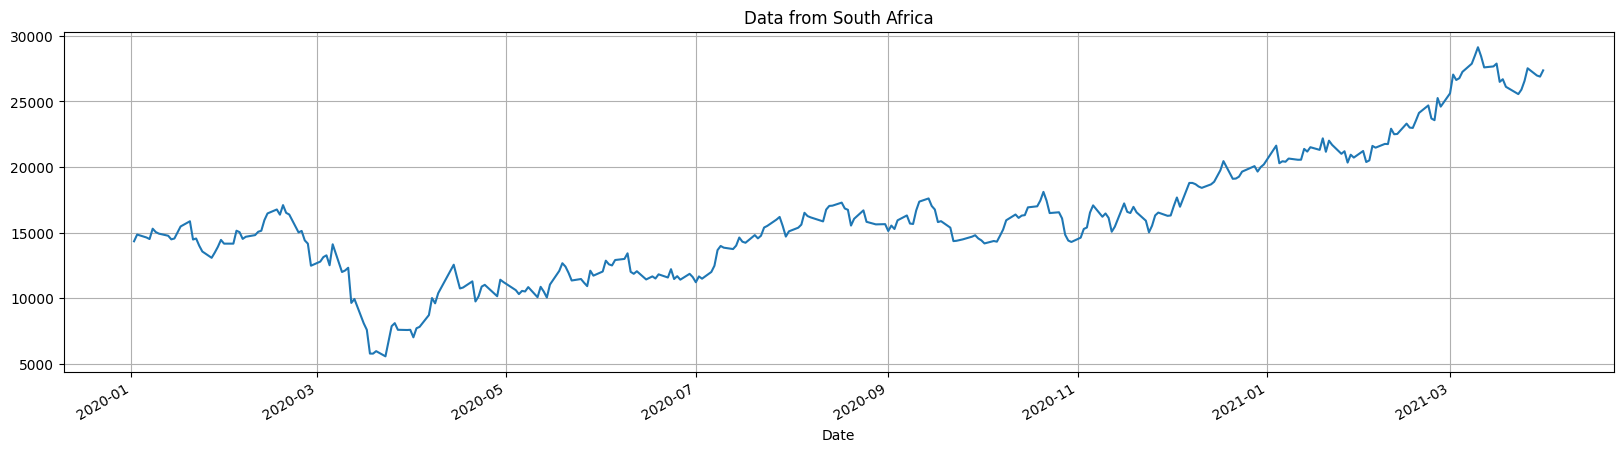

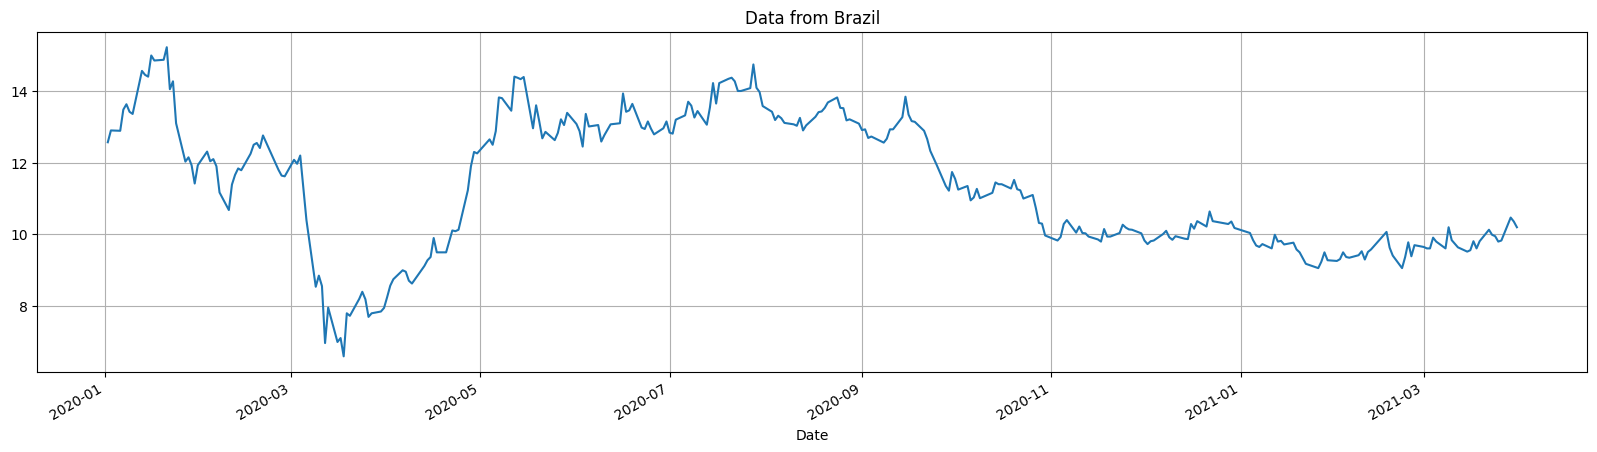

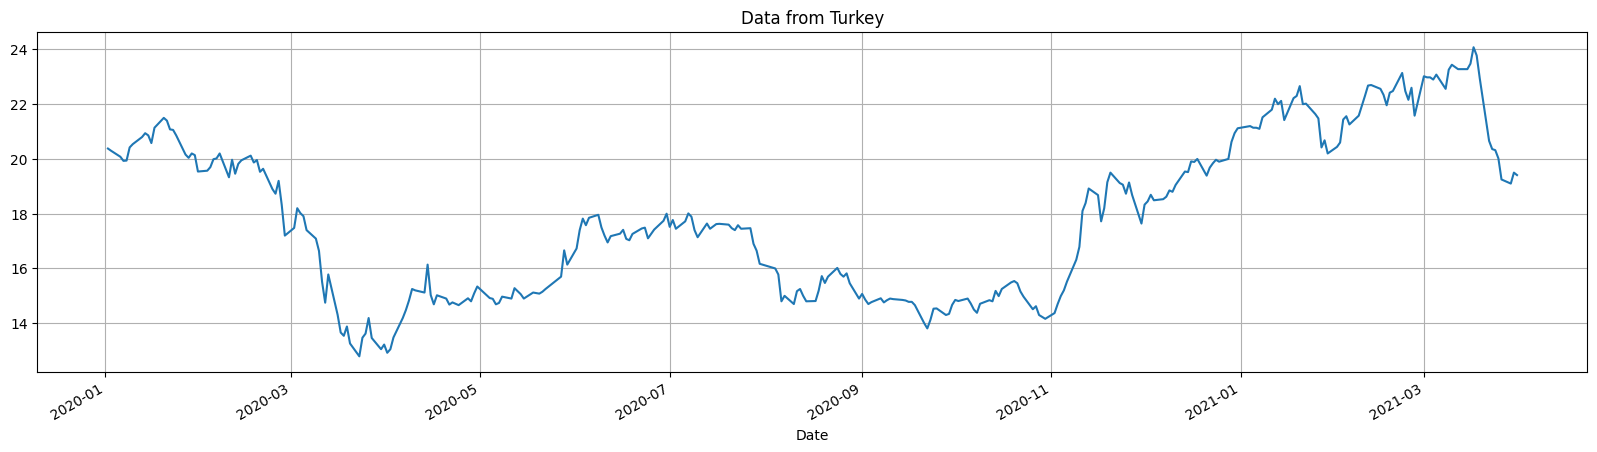

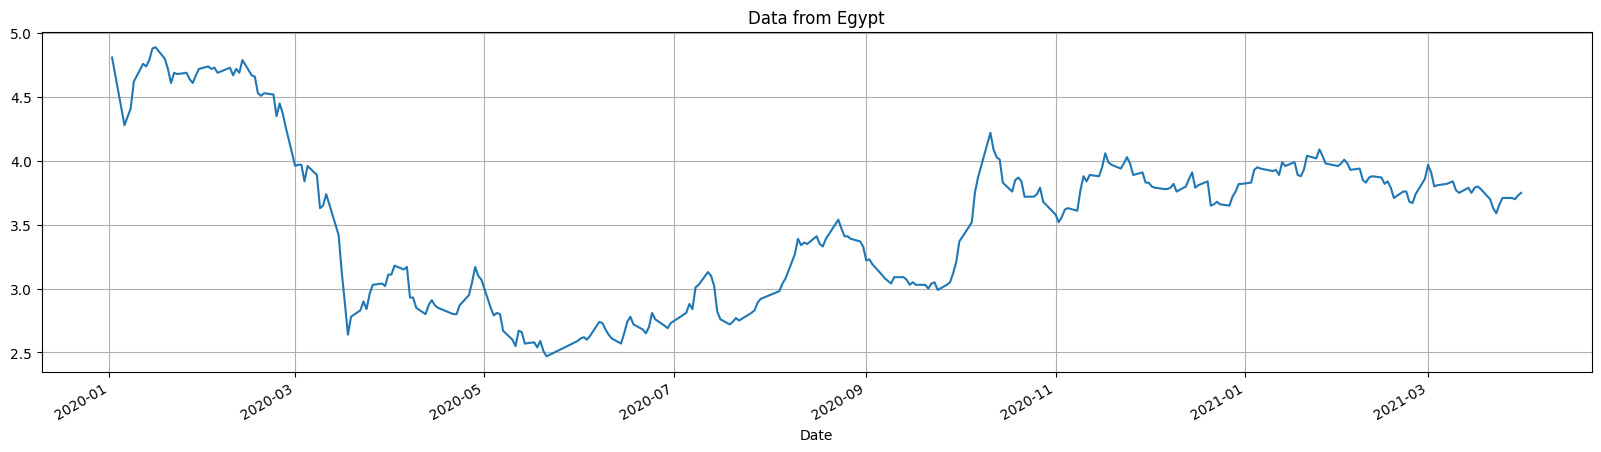

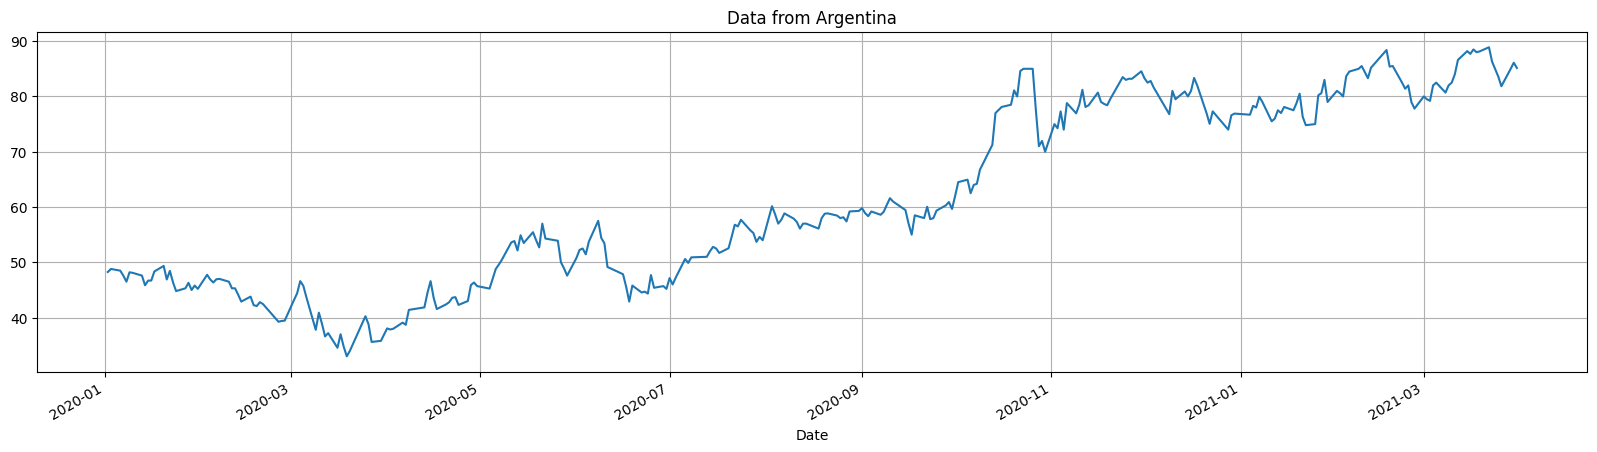

In [ ]:
for key in data.keys():
  data[key].plot(figsize=(20,5), title=f'Data from {key}', grid='on')
  plt.show()

We notice that the time series have **different values**.

Let's **normalize** them

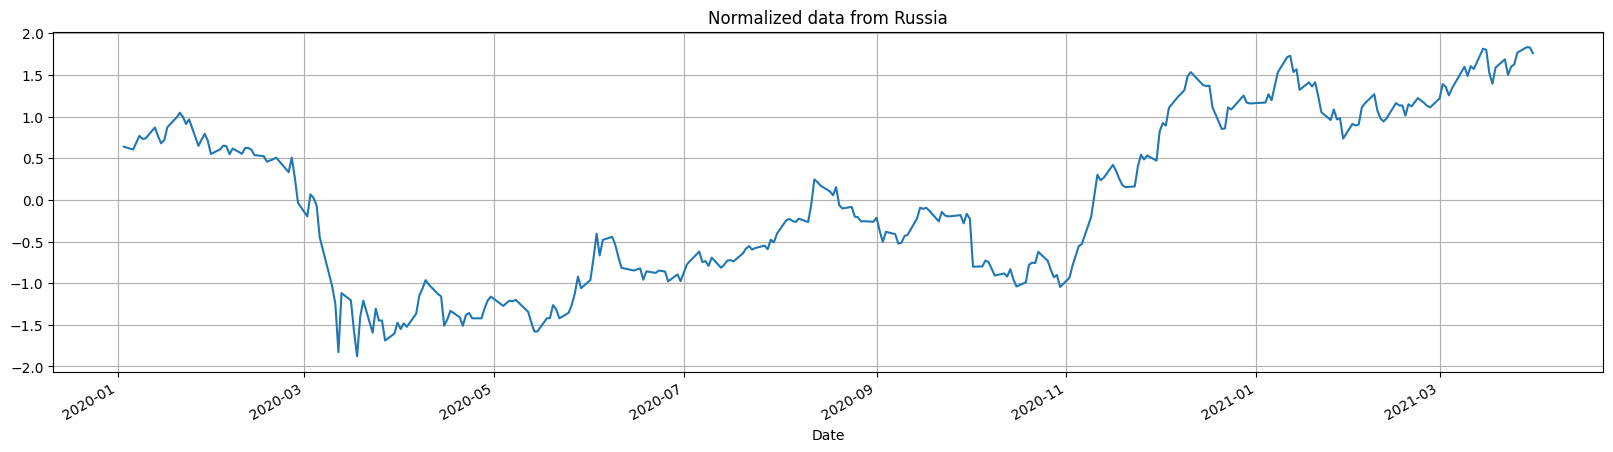

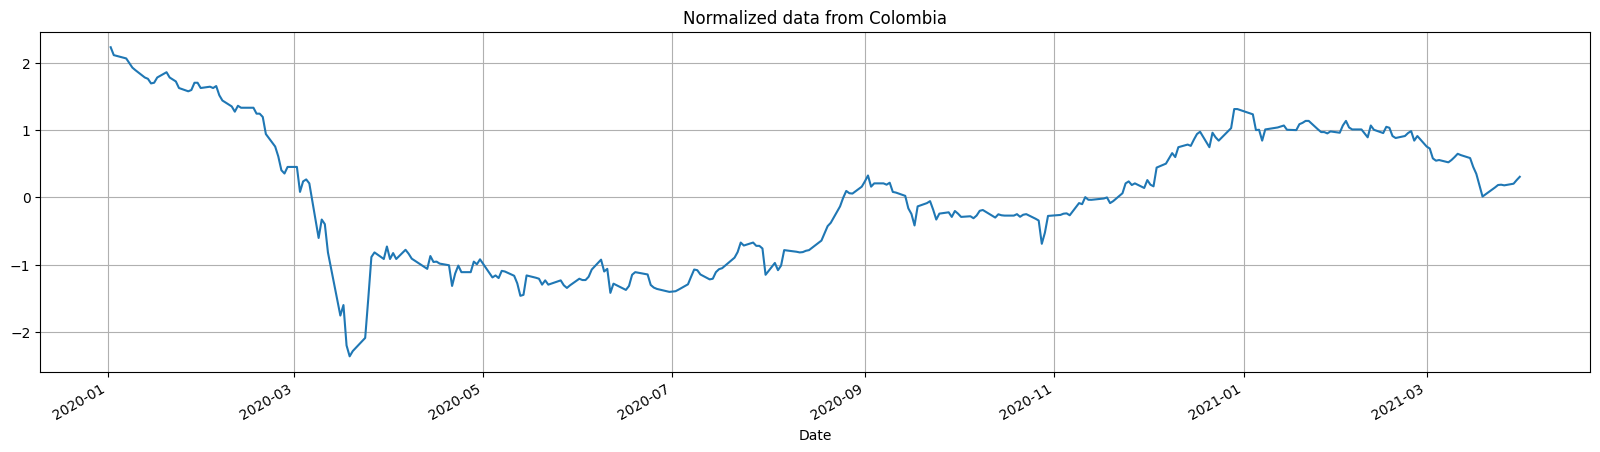

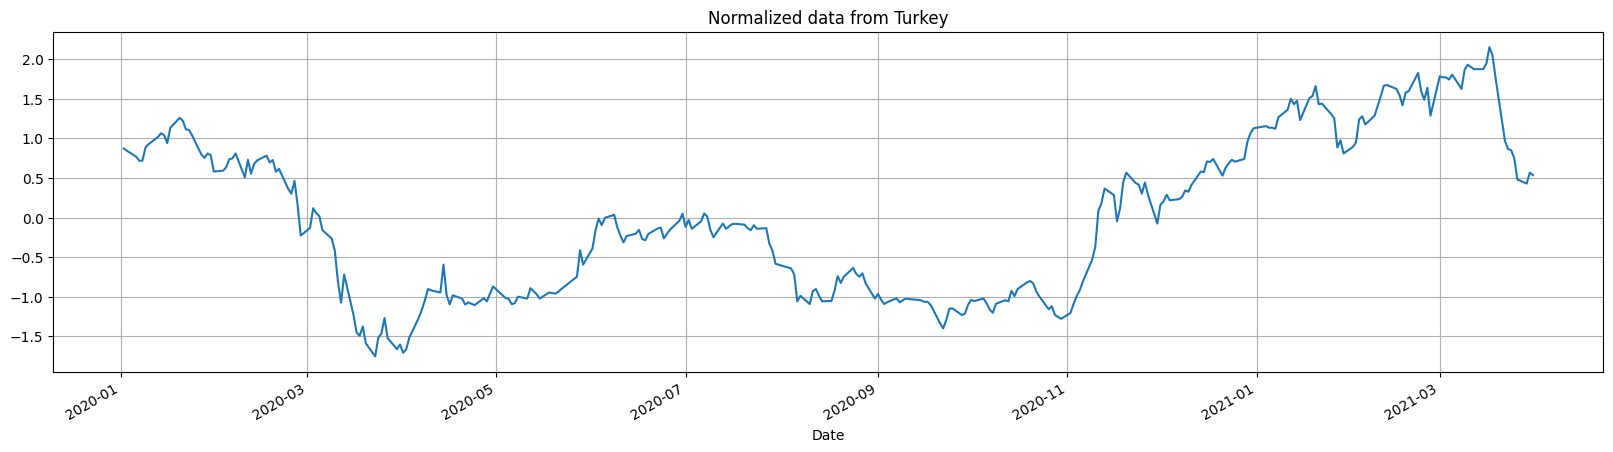

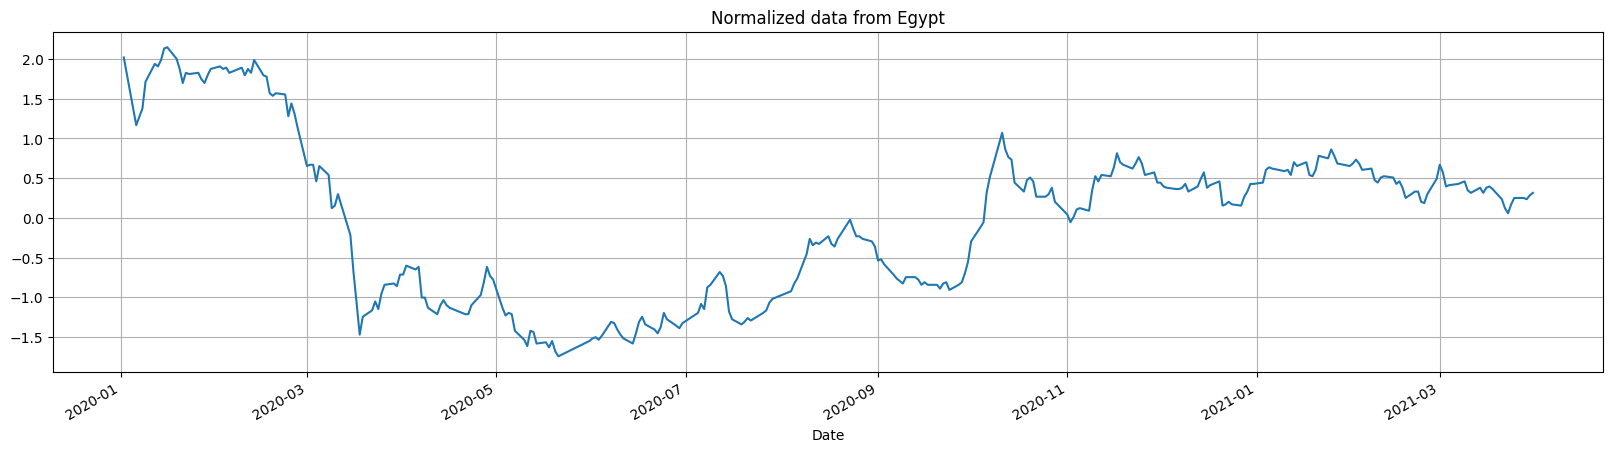

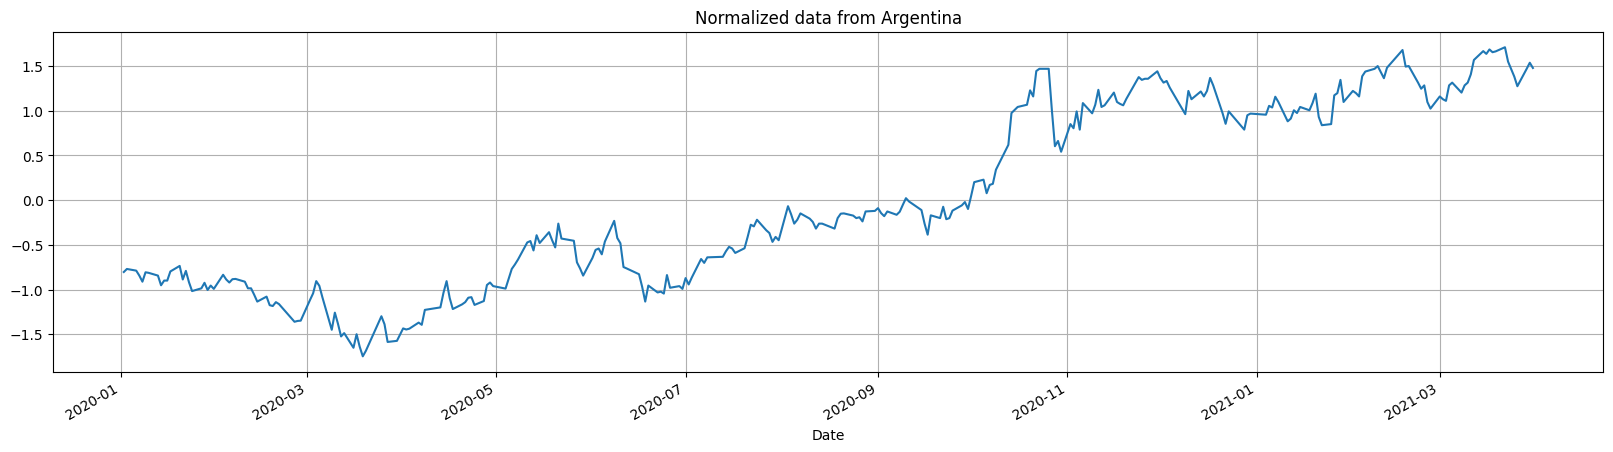

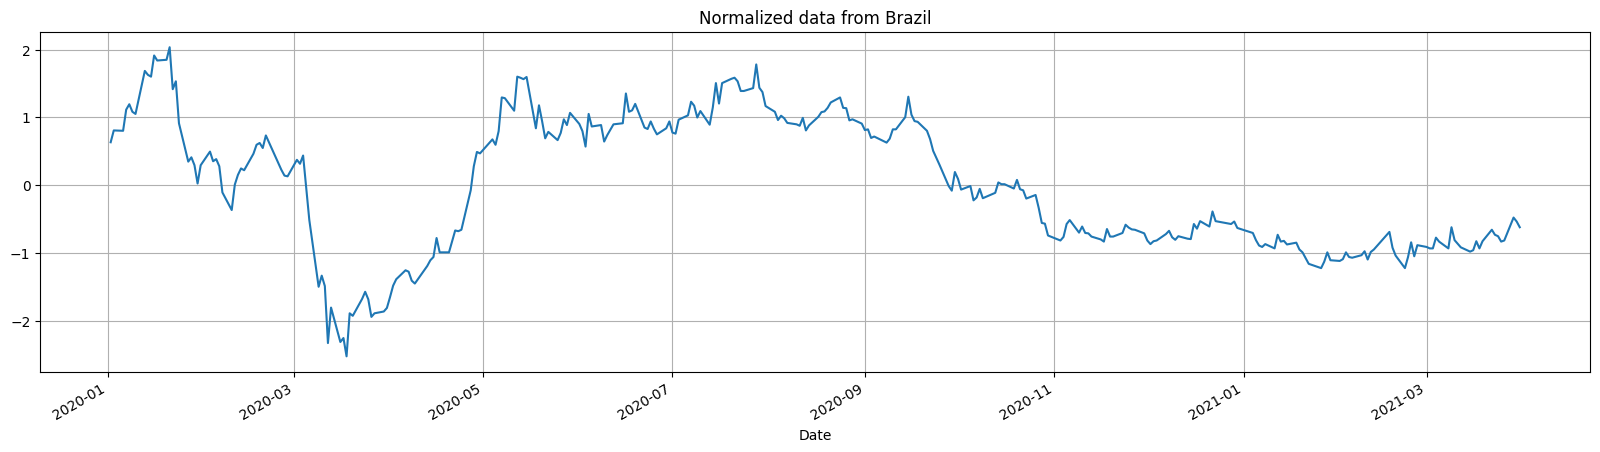

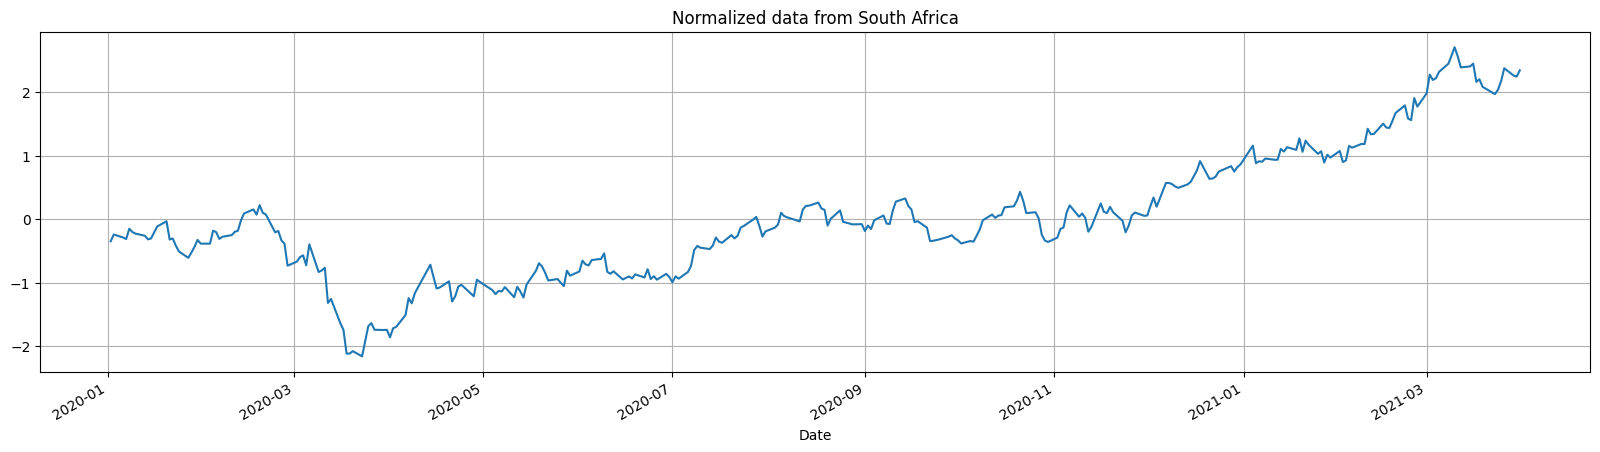

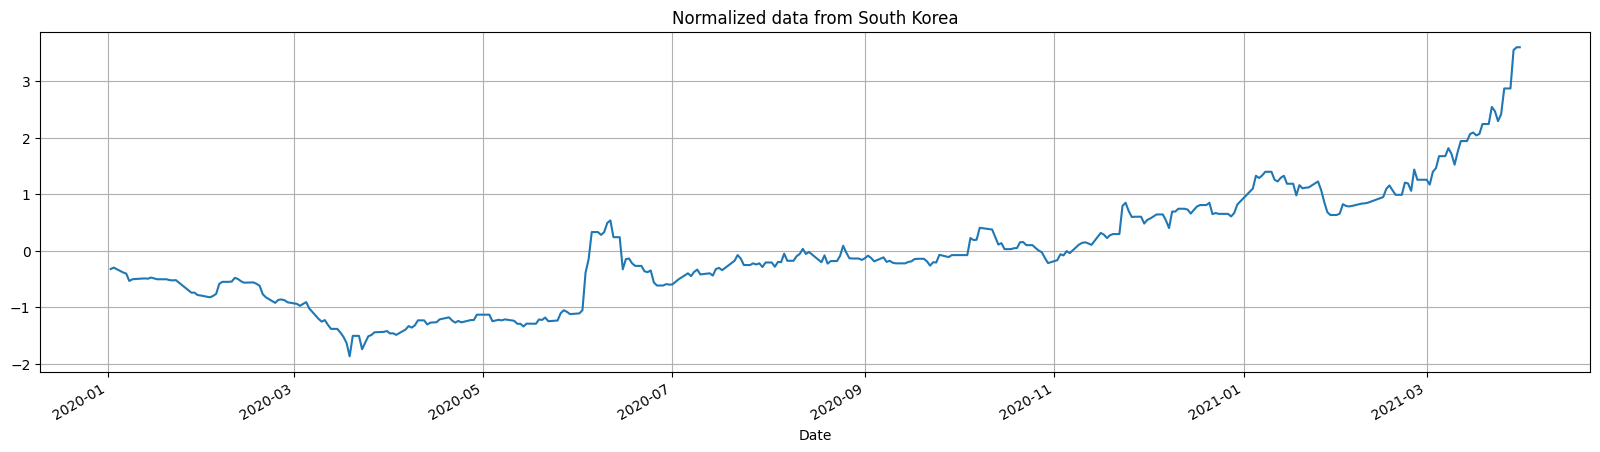

In [12]:
norm_data = {}

for key in data.keys():
  price = data[key]
  avg, dev = price.mean(), price.std()
  norm_price = (price - avg) / dev
  norm_data[key] = norm_price

  ax = norm_price.plot(figsize=(20,5), title=f'Normalized data from {key}', grid='on')
  plt.show()

# EDA - stationarity

We verify the stationarity of the time series using the **Augmented Dickey-Fuller** test

In [13]:
exp_data = norm_data['Argentina']
exp_data = exp_data.asfreq('b')
exp_data = exp_data.fillna(method='ffill')

results = adfuller(exp_data)
print('The p-value of the series is: ', results[1])

The p-value of the series is:  0.8756756136964812


Since the p-value of the series is **greater than 0.5**, then the series is **not stationary**.

Looking at the data, most likely the non stationarity is due to the presence of a **trend** and (maybe) of a seasonal component.

Let's try and split the series in the components using the available tool, assuming that the model is **additive**

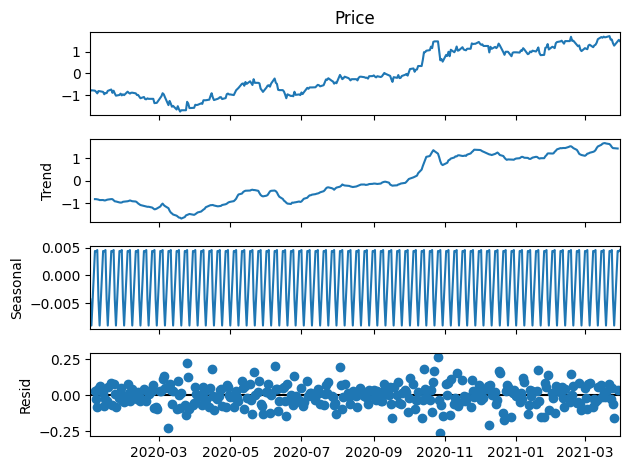

In [14]:
decomposition = sm.tsa.seasonal_decompose(exp_data, model='additive')
fig = decomposition.plot()

From the above graph we can see that a **trend** is clearly present, and maybe also a weekly seasonality.

Let's compute the **first order differences** to try removing the trend and verify the stationarity of the new series

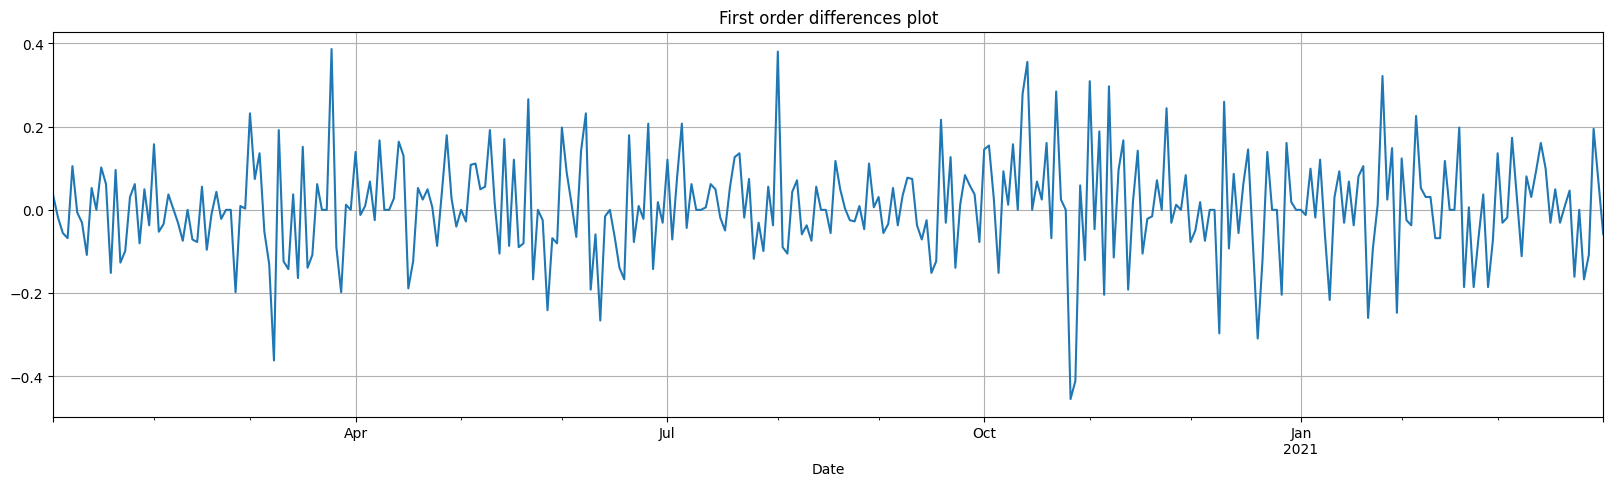

The p-value of the series is:  0.0


In [15]:
diff_exp_data = exp_data.diff().dropna()

diff_exp_data.plot(figsize=(20,5), title=f'First order differences plot', grid='on')
plt.show()

results = adfuller(diff_exp_data)
print('The p-value of the series is: ', results[1])

In this case the p-value is **zero**, so the series is stationary.

Hence, from now on we will work on the first order differences time series rather then on the original one

# EDA - autocorrelation

let's compute the autocorrelation of the diff series

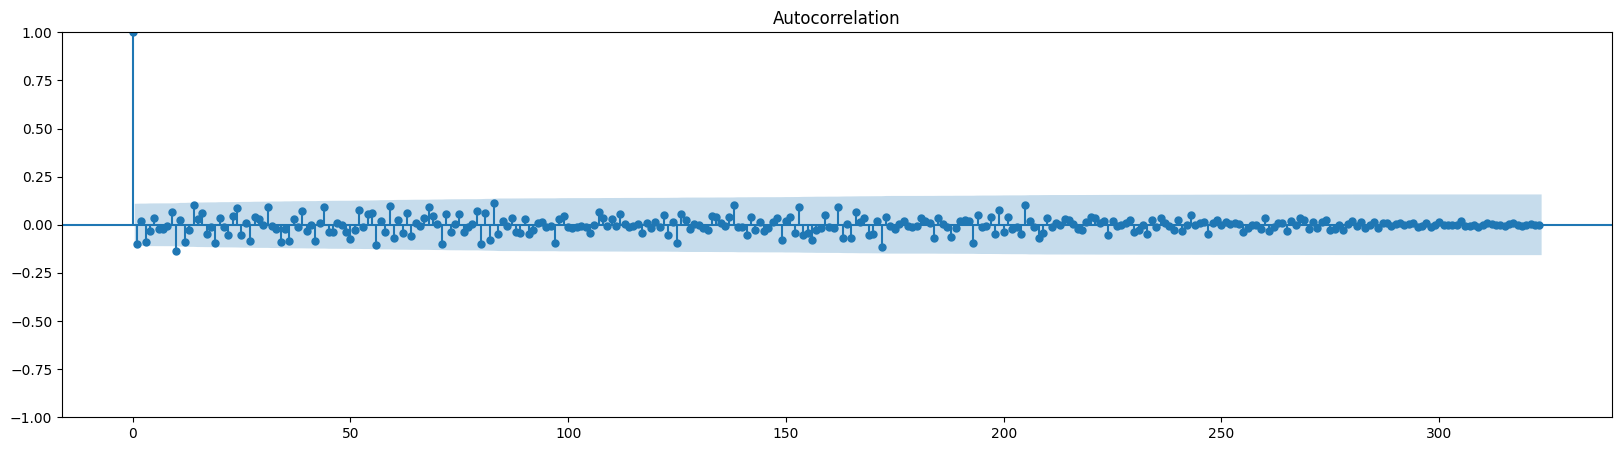

In [19]:
plt.figure(figsize=(20, 5))
sm.graphics.tsa.plot_acf(diff_exp_data, lags=len(diff_exp_data)-1, ax=plt.gca())
plt.show()

Let's now compute the **partial** autocorrelation of the diff series

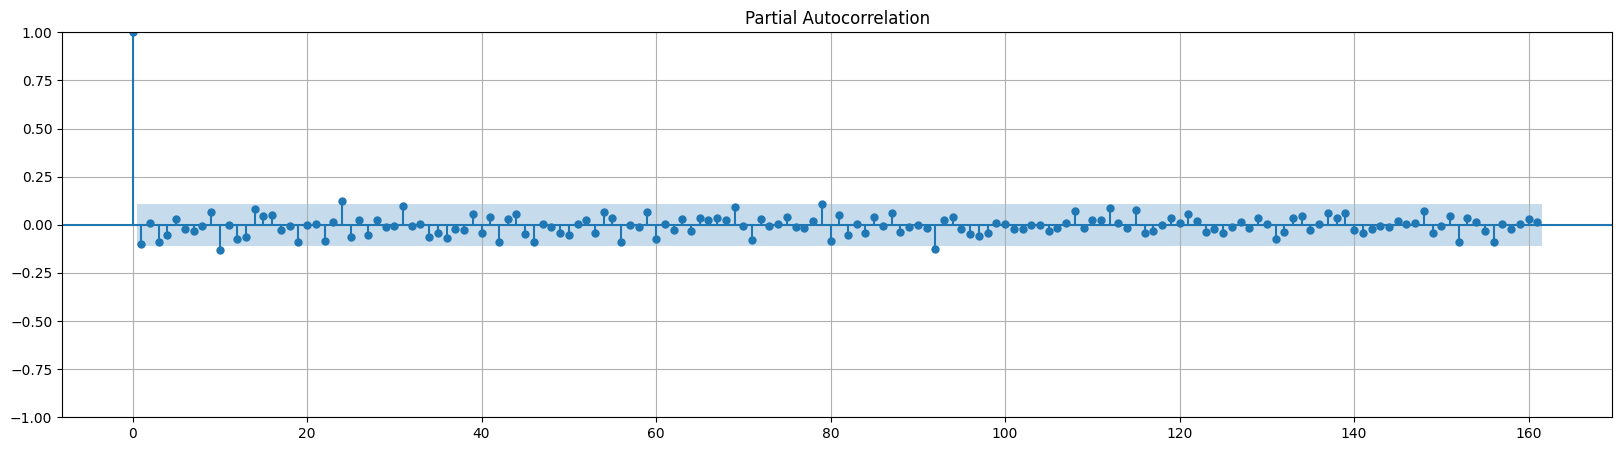

In [25]:
plt.figure(figsize=(20, 5))
sm.graphics.tsa.plot_pacf(diff_exp_data, lags=len(diff_exp_data)/2 -1, ax=plt.gca())
plt.grid(True)
plt.show()

Let's have a closer look to the partial autocorrelation of small lags

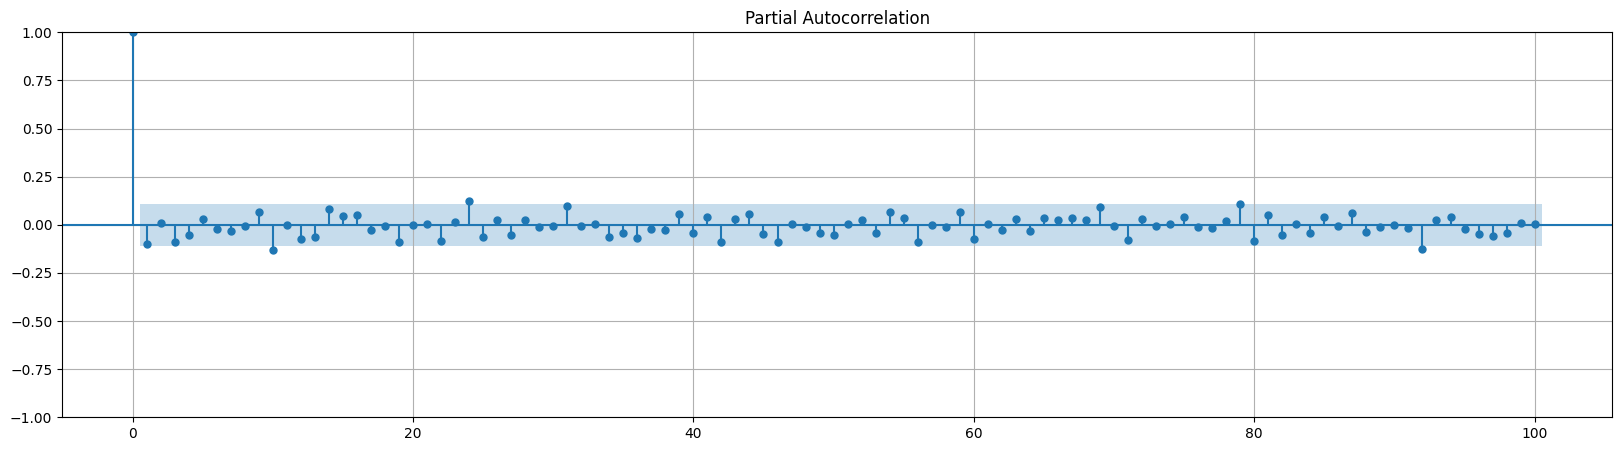

In [26]:
plt.figure(figsize=(20, 5))
sm.graphics.tsa.plot_pacf(diff_exp_data, lags=100, ax=plt.gca())
plt.grid(True)
plt.show()

There are some lag values that have somehow **statistically meaningful** correlation:

1, 10, 24, 79 and 92

But what if we analyze another time series?

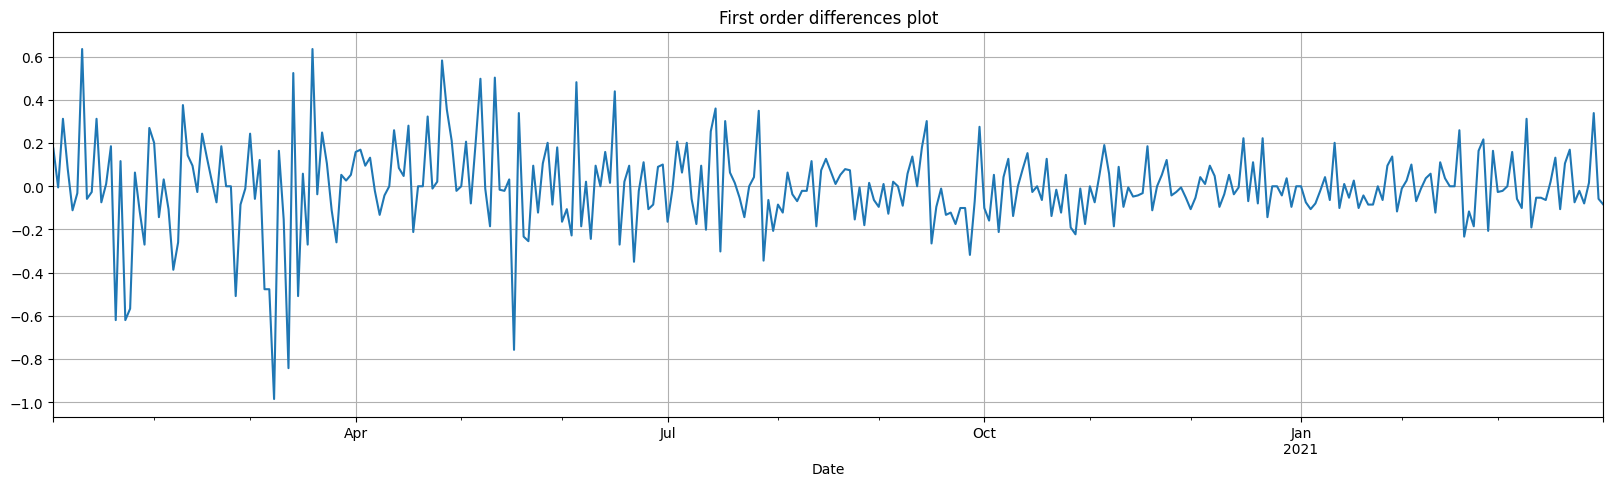

The p-value of the series is:  8.178484025779254e-14


In [27]:
exp_data = norm_data['Brazil']
exp_data = exp_data.asfreq('b')
exp_data = exp_data.fillna(method='ffill')

diff_exp_data = exp_data.diff().dropna()

diff_exp_data.plot(figsize=(20,5), title=f'First order differences plot', grid='on')
plt.show()

results = adfuller(diff_exp_data)
print('The p-value of the series is: ', results[1])

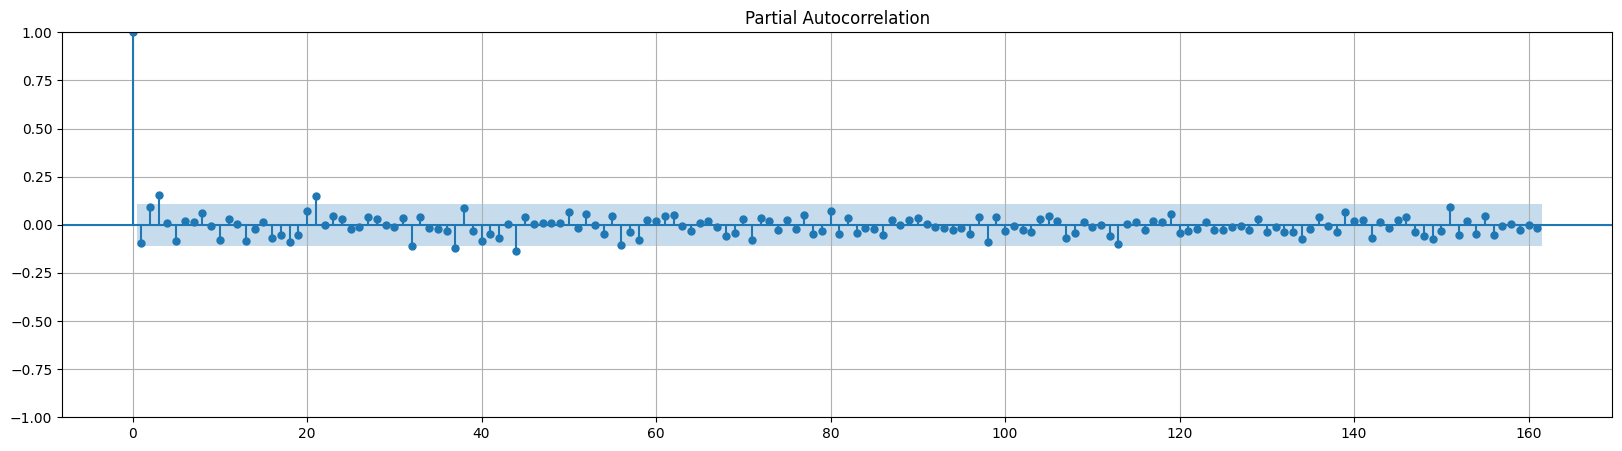

In [28]:
plt.figure(figsize=(20, 5))
sm.graphics.tsa.plot_pacf(diff_exp_data, lags=len(diff_exp_data)/2 -1, ax=plt.gca())
plt.grid(True)
plt.show()

We observe that the relevant lag values are **different** than the previous ones:

1, 3, 21, 32, 37, 44, 56, 113

# Pre processing

There is clearly a growing trend in the data.

Let's remove it using **first difference**

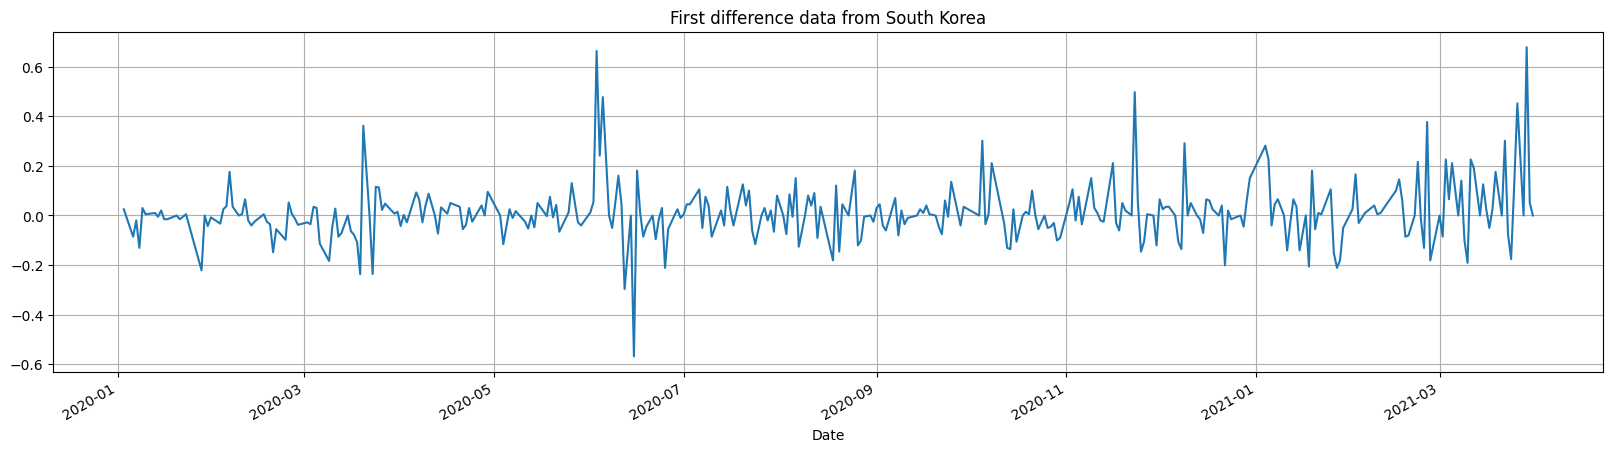

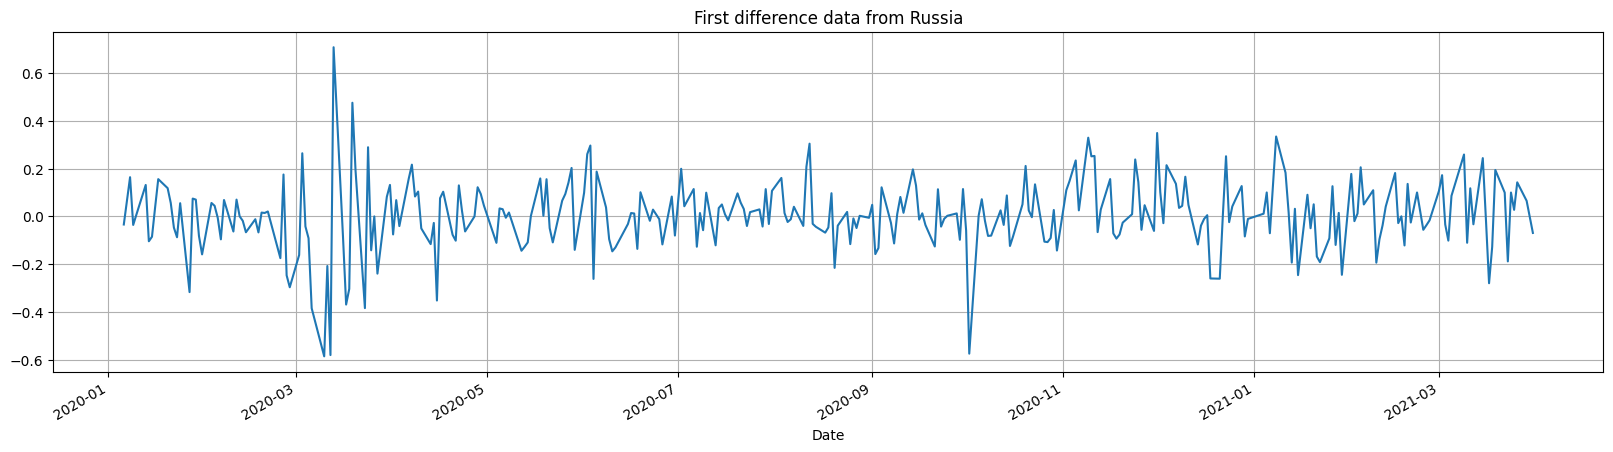

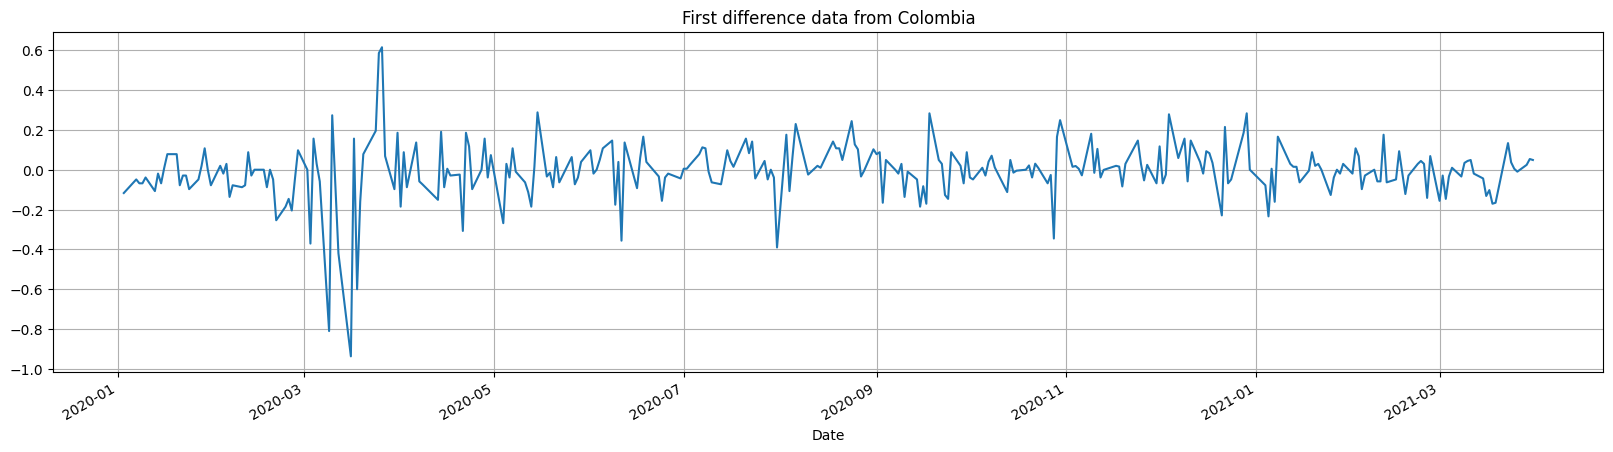

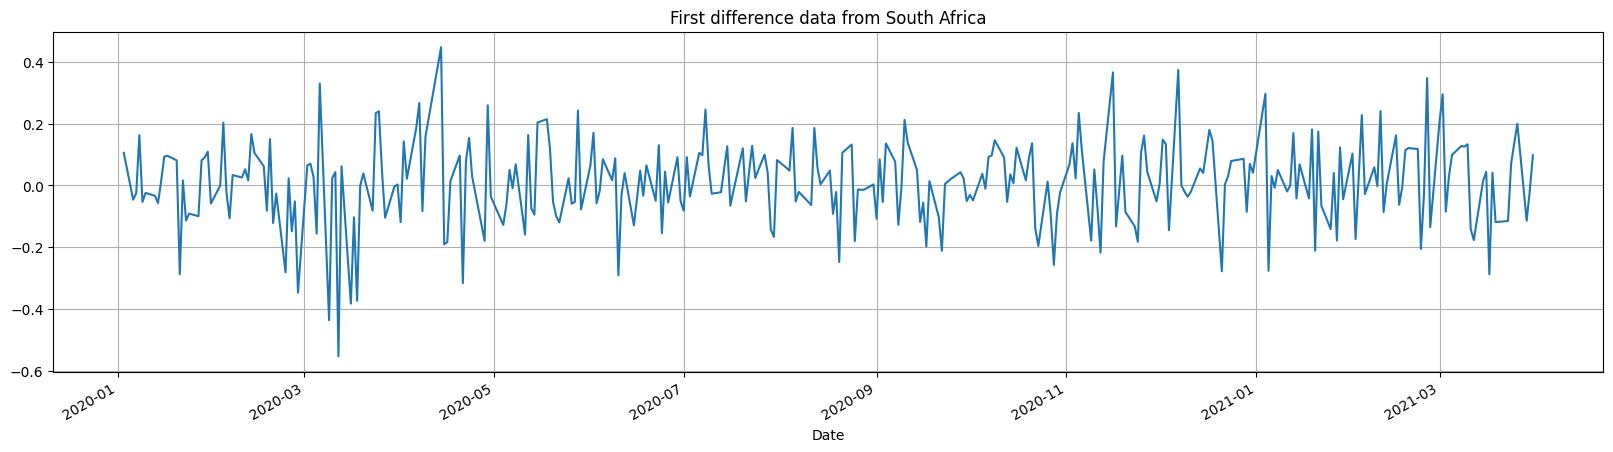

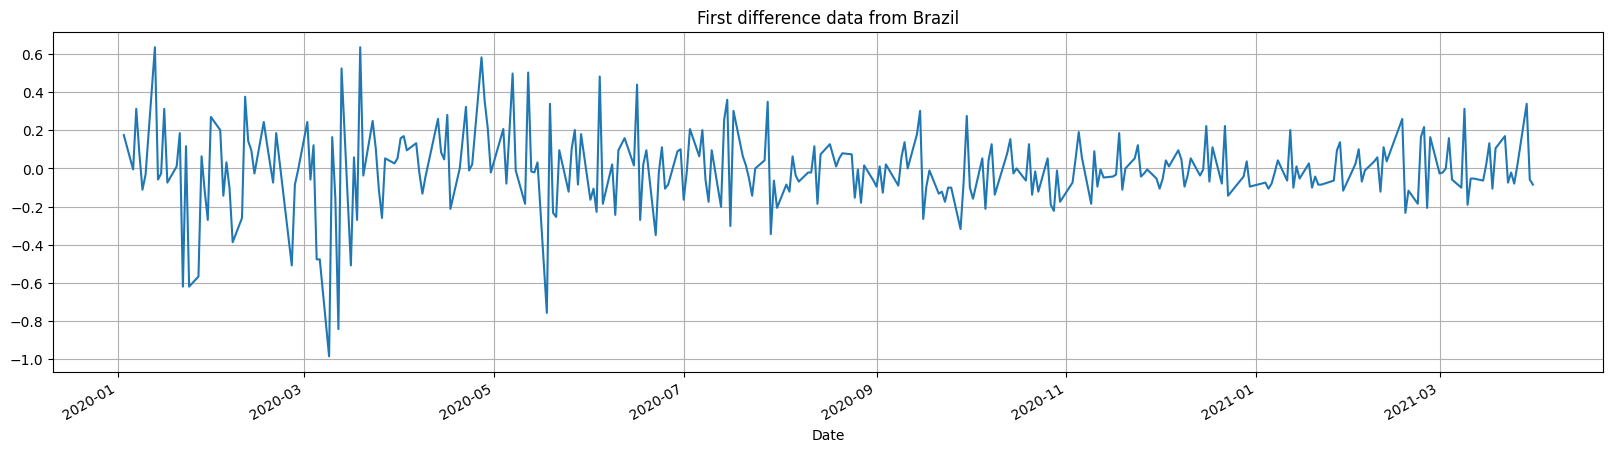

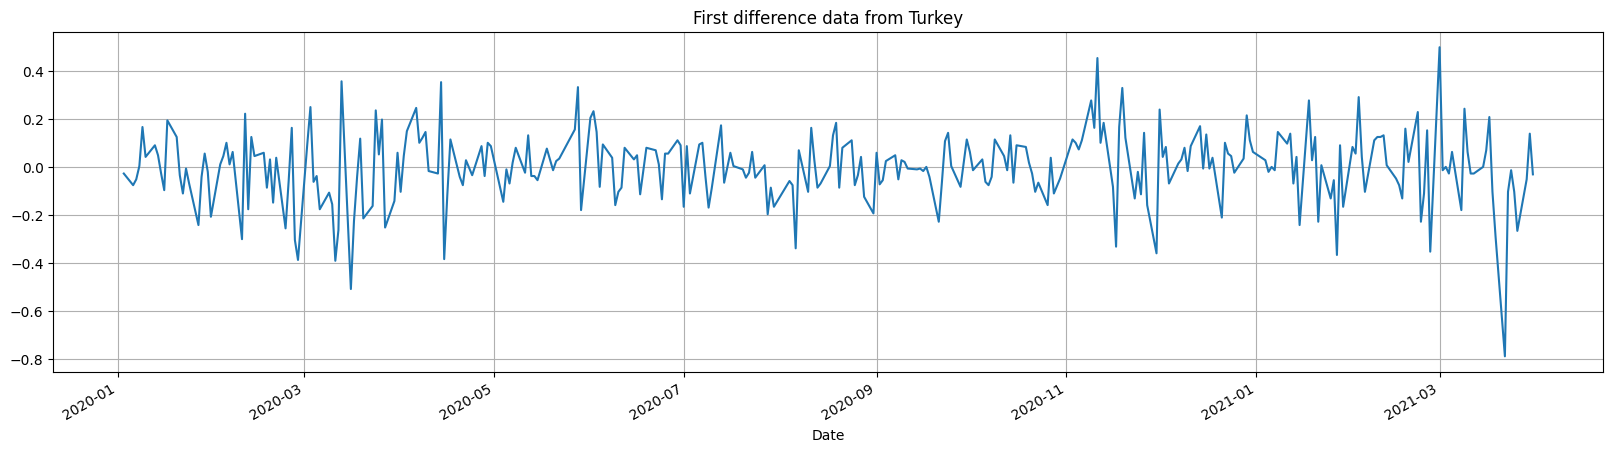

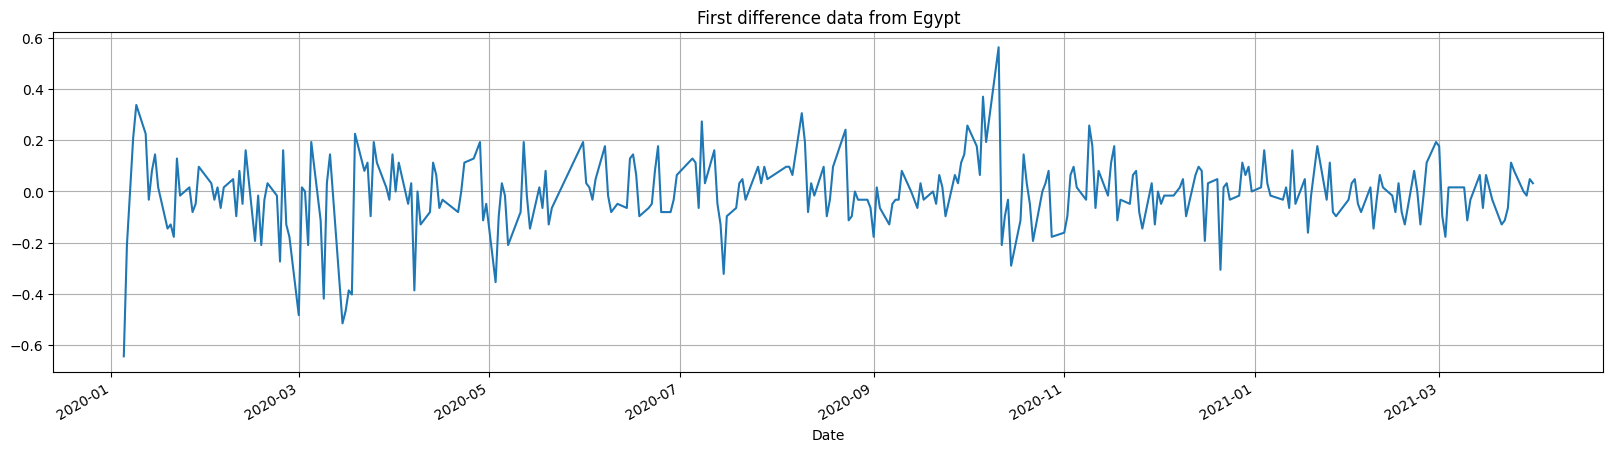

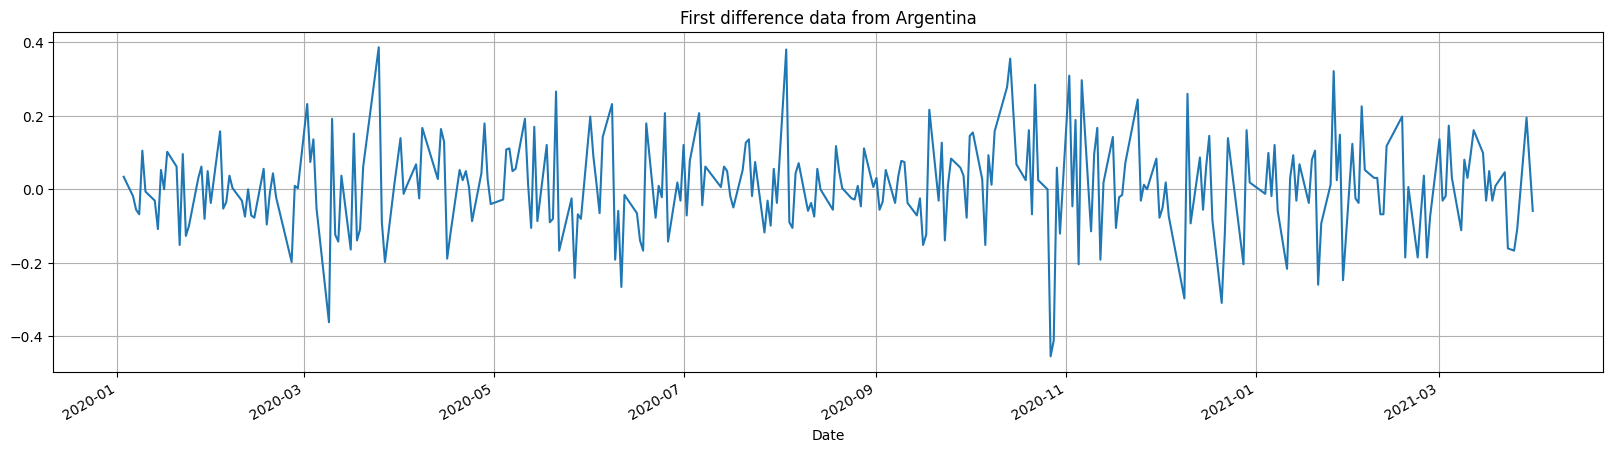

In [ ]:
diff_data = {}

for key in norm_data.keys():
  diff_price = norm_data[key].diff().dropna()
  diff_data[key] = diff_price

  # fig = plt.Figure()
  ax = diff_price.plot(figsize=(20,5), title=f'First difference data from {key}', grid='on')
  # ax.set_title(f'Data from {key}')
  plt.show()

Now the time series look much more **stationary**.